In [13]:
# from torch.utils.data import DataLoader
import torch.nn as nn
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score
import random


In [14]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
set_seed(42)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [16]:
loaded_data = torch.load("../data/gcn_dataset.pt", weights_only=False)

dataset_S = loaded_data["dataset_S"]
dataset_F = loaded_data["dataset_F"]
dataset_FA = loaded_data["dataset_FA"]
dataset_FAA = loaded_data["dataset_FAA"]
print("Datasets loaded successfully")


Datasets loaded successfully


In [17]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p, num_layers):
        super(GCN, self).__init__()
        self.num_layers = num_layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.convs = torch.nn.ModuleList([
            GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers - 2)
        ])
        self.conv_out = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout_p = dropout_p

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
        if edge_weight is None:
            print("Funckin none")
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_weight)
            x = F.relu(x)
            x = F.dropout(x, p = self.dropout_p, training=self.training)
        x = self.conv_out(x, edge_index, edge_weight)
        x = global_mean_pool(x, batch) 
        x = self.fc(x)
        return x

In [18]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data).view(-1)
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data).view(-1)
        pred = (torch.sigmoid(out) >= 0.5).int()
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

def get_baseline_acc(loader):
    num_true = 0
    for data in loader:
        num_true += int(data.y.sum())
    return num_true / len(loader.dataset)

def test_with_auc(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).view(-1)
            preds = torch.sigmoid(out).cpu().numpy()
            labels = data.y.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)
    
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    return fpr, tpr, auc

def evaluate_with_fixed_threshold_precision(model, loader):
    threshold=0.5
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).view(-1)
            pred = (torch.sigmoid(out) >= threshold).int()
            labels = data.y.cpu().numpy()

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels)

    precision = precision_score(all_labels, all_preds, zero_division=0)
    
    return precision

def evaluate_with_fixed_threshold_recall(model, loader):
    threshold = 0.5
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).view(-1)
            pred = (torch.sigmoid(out) >= threshold).int()
            labels = data.y.cpu().numpy()

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels)
    
    recall = recall_score(all_labels, all_preds, zero_division=0)
    
    return recall

In [19]:
criterion = nn.BCEWithLogitsLoss()
output_dim = 1
K = 10 
kf = KFold(n_splits=K, shuffle=True, random_state=42)

### Shaple Only (S)

In [20]:
lr = 0.001
batch_size = 32
hidden_dim = 128
dropout_p = 0.3
num_layer = 3
num_epochs = 100

input_dim = 5

splits = kf.split(dataset_S)

train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
precisions, recalls = [0] * num_epochs, [0] * num_epochs

epoch_fprs = [[] for _ in range(num_epochs)]
epoch_tprs = [[] for _ in range(num_epochs)]
mean_fpr = np.linspace(0, 1, 100)


for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):
    train_dataset = [dataset_S[i] for i in train_idx]
    test_dataset = [dataset_S[i] for i in test_idx]
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

    set_seed(42)
    model = GCN(input_dim, hidden_dim, output_dim, dropout_p, num_layer).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    for epoch in range(num_epochs):
        loss = train(model, optimizer, criterion, train_loader)
        train_acc = test(model, train_loader)
        test_acc = test(model, test_loader)
        fpr, tpr, _ = test_with_auc(model, test_loader)
        precision = evaluate_with_fixed_threshold_precision(model, test_loader)
        recall = evaluate_with_fixed_threshold_recall(model, test_loader)

        train_accs[epoch] += train_acc
        test_accs[epoch] += test_acc
        precisions[epoch] += precision
        recalls[epoch] += recall

        epoch_fprs[epoch].append(fpr)
        epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))
        epoch_tprs[epoch][-1][0]= 0.0



10it [00:24,  2.47s/it]


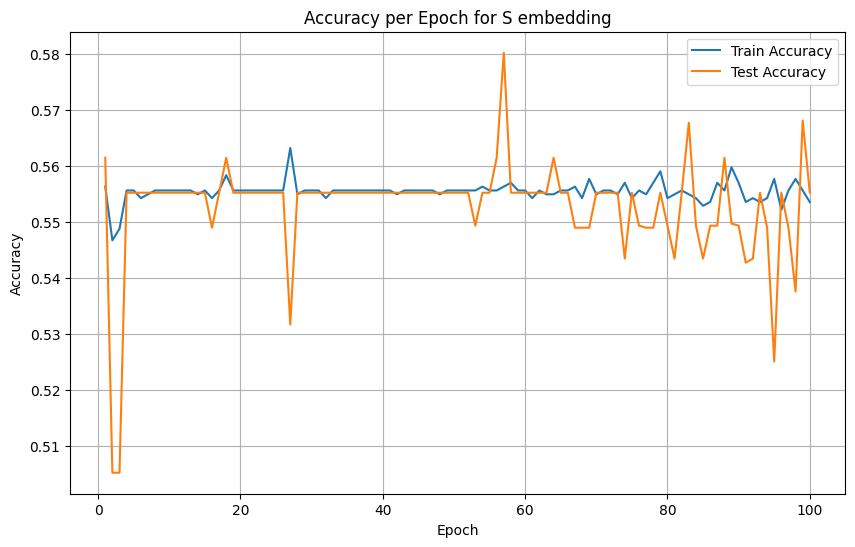

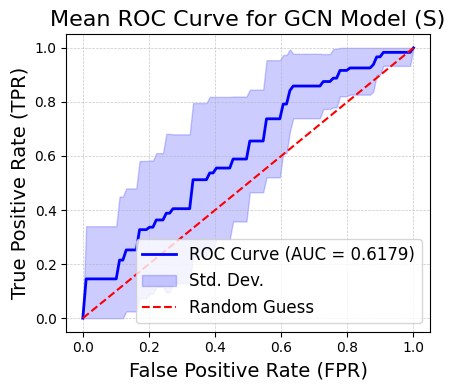

Epoch = 56
Best_mean_accuracy: 0.5801
Best mean_roc_auc: 0.6179
Best mean_precision: 0.2600
Best mean_recall: 0.1179


In [21]:
mean_train_accs = [acc / 10 for acc in train_accs]
mean_test_accs = [acc / 10 for acc in test_accs]
mean_precisions = [pre / 10 for pre in precisions]
mean_recalls = [recall / 10 for recall in recalls]

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per Epoch for S embedding')
plt.legend()
plt.grid(True)
plt.show()


    
best_mean_accuracy = max(mean_test_accs)
best_epoch = mean_test_accs.index(best_mean_accuracy)
mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
mean_tpr[-1] = 1.0
mean_roc_auc = auc(mean_fpr, mean_tpr)

# Plot ROC Curve for the best epoch
plt.figure(figsize=(4.5, 4))
plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'Mean ROC Curve for GCN Model (S)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Epoch = {best_epoch}")
print(f"Best_mean_accuracy: {best_mean_accuracy:.4f}")
print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")

### Function Type Only (F)

In [22]:
lr = 0.001
batch_size = 16
hidden_dim = 64
dropout_p = 0.8
num_layer = 3
num_epochs = 100

input_dim = 5

splits = kf.split(dataset_F)

train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
precisions, recalls = [0] * num_epochs, [0] * num_epochs

epoch_fprs = [[] for _ in range(num_epochs)]
epoch_tprs = [[] for _ in range(num_epochs)]
mean_fpr = np.linspace(0, 1, 100)

for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):
    train_dataset = [dataset_F[i] for i in train_idx]
    test_dataset = [dataset_F[i] for i in test_idx]
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

    set_seed(42)
    model = GCN(input_dim, hidden_dim, output_dim, dropout_p, num_layer).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    for epoch in range(num_epochs):
        loss = train(model, optimizer, criterion, train_loader)
        train_acc = test(model, train_loader)
        test_acc = test(model, test_loader)
        fpr, tpr, _ = test_with_auc(model, test_loader)
        precision = evaluate_with_fixed_threshold_precision(model, test_loader)
        recall = evaluate_with_fixed_threshold_recall(model, test_loader)

        train_accs[epoch] += train_acc
        test_accs[epoch] += test_acc
        precisions[epoch] += precision
        recalls[epoch] += recall

        epoch_fprs[epoch].append(fpr)
        epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))
        epoch_tprs[epoch][-1][0]= 0.0




10it [00:31,  3.13s/it]


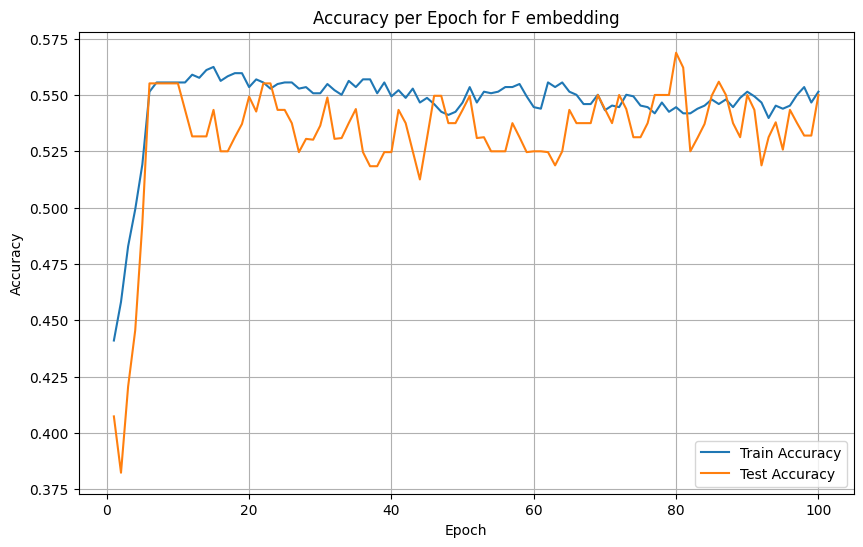

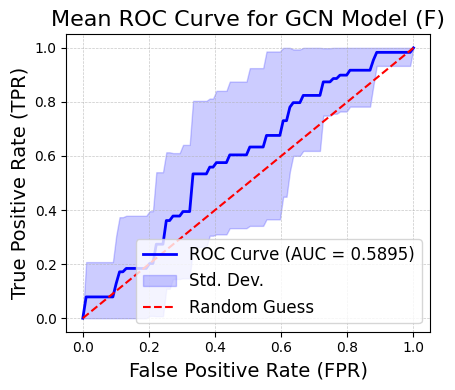

Epoch = 79
Best_mean_accuracy: 0.5687
Best mean_roc_auc: 0.5895
Best mean_precision: 0.2800
Best mean_recall: 0.1529


In [23]:
mean_train_accs = [acc / 10 for acc in train_accs]
mean_test_accs = [acc / 10 for acc in test_accs]
mean_precisions = [pre / 10 for pre in precisions]
mean_recalls = [recall / 10 for recall in recalls]

best_mean_accuracy = max(mean_test_accs)
best_epoch = mean_test_accs.index(best_mean_accuracy)
mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
mean_tpr[-1] = 1.0
mean_roc_auc = auc(mean_fpr, mean_tpr)

# Plot accuracy graphs over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per Epoch for F embedding')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC Curve for the best epoch
plt.figure(figsize=(4.5, 4))
plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'Mean ROC Curve for GCN Model (F)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()
    
print(f"Epoch = {best_epoch}")
print(f"Best_mean_accuracy: {mean_test_accs[best_epoch]:.4f}")
print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")

### 

### Function Type and Arguments (F+A)

In [24]:
lr = 0.001
batch_size = 16
hidden_dim = 64
dropout_p = 0.8
num_layer = 3
num_epochs = 100

input_dim = 33

splits = kf.split(dataset_FA)

train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
precisions, recalls = [0] * num_epochs, [0] * num_epochs

epoch_fprs = [[] for _ in range(num_epochs)]
epoch_tprs = [[] for _ in range(num_epochs)]
mean_fpr = np.linspace(0, 1, 100)

for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):
    train_dataset = [dataset_FA[i] for i in train_idx]
    test_dataset = [dataset_FA[i] for i in test_idx]
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

    set_seed(42)
    model = GCN(input_dim, hidden_dim, output_dim, dropout_p, num_layer).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    for epoch in range(num_epochs):
        loss = train(model, optimizer, criterion, train_loader)
        train_acc = test(model, train_loader)
        test_acc = test(model, test_loader)
        fpr, tpr, _ = test_with_auc(model, test_loader)
        precision = evaluate_with_fixed_threshold_precision(model, test_loader)
        recall = evaluate_with_fixed_threshold_recall(model, test_loader)

        train_accs[epoch] += train_acc
        test_accs[epoch] += test_acc
        precisions[epoch] += precision
        recalls[epoch] += recall

        epoch_fprs[epoch].append(fpr)
        epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))
        epoch_tprs[epoch][-1][0]= 0.0



10it [00:33,  3.38s/it]


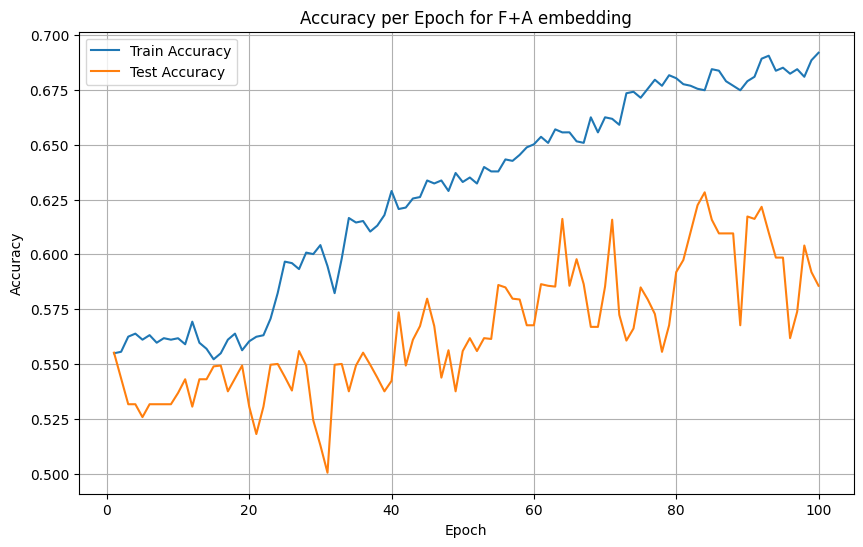

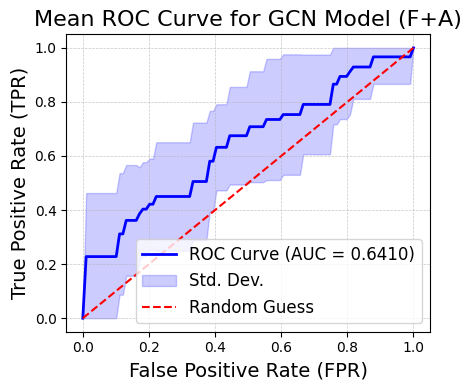

Epoch = 83
Best_mean_accuracy: 0.6283
Best mean_roc_auc: 0.6410
Best mean_precision: 0.6362
Best mean_recall: 0.4558


In [25]:
mean_train_accs = [acc / 10 for acc in train_accs]
mean_test_accs = [acc / 10 for acc in test_accs]
mean_precisions = [pre / 10 for pre in precisions]
mean_recalls = [recall / 10 for recall in recalls]

best_mean_accuracy = max(mean_test_accs)
best_epoch = mean_test_accs.index(best_mean_accuracy)
mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
mean_tpr[-1] = 1.0
mean_roc_auc = auc(mean_fpr, mean_tpr)

# Plot accuracy graphs over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per Epoch for F+A embedding')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC Curve for the best epoch
plt.figure(figsize=(4.5, 4))
plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'Mean ROC Curve for GCN Model (F+A)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()
    
print(f"Epoch = {best_epoch}")
print(f"Best_mean_accuracy: {mean_test_accs[best_epoch]:.4f}")
print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")

### Function Type, Arguments and Answer (F+A+A)

In [26]:
lr = 0.001
batch_size = 16
hidden_dim = 64
dropout_p = 0.8
num_layer = 3
num_epochs = 100

input_dim = 33

splits = kf.split(dataset_FAA)

train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
precisions, recalls = [0] * num_epochs, [0] * num_epochs

epoch_fprs = [[] for _ in range(num_epochs)]
epoch_tprs = [[] for _ in range(num_epochs)]
mean_fpr = np.linspace(0, 1, 100)

for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):
    train_dataset = [dataset_FAA[i] for i in train_idx]
    test_dataset = [dataset_FAA[i] for i in test_idx]
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

    set_seed(42)
    model = GCN(input_dim, hidden_dim, output_dim, dropout_p, num_layer).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    for epoch in range(num_epochs):
        loss = train(model, optimizer, criterion, train_loader)
        train_acc = test(model, train_loader)
        test_acc = test(model, test_loader)
        fpr, tpr, _ = test_with_auc(model, test_loader)
        precision = evaluate_with_fixed_threshold_precision(model, test_loader)
        recall = evaluate_with_fixed_threshold_recall(model, test_loader)

        train_accs[epoch] += train_acc
        test_accs[epoch] += test_acc
        precisions[epoch] += precision
        recalls[epoch] += recall

        epoch_fprs[epoch].append(fpr)
        epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))  
        epoch_tprs[epoch][-1][0] = 0.0  
 


10it [00:34,  3.41s/it]


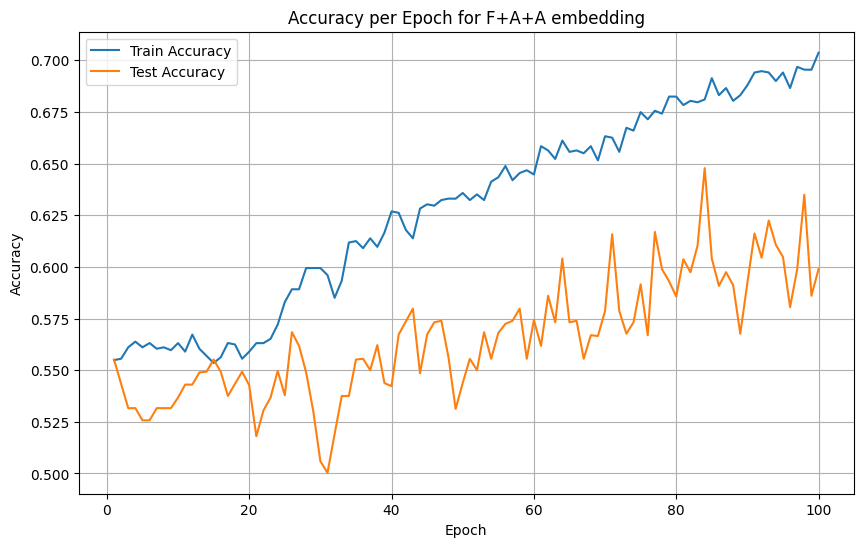

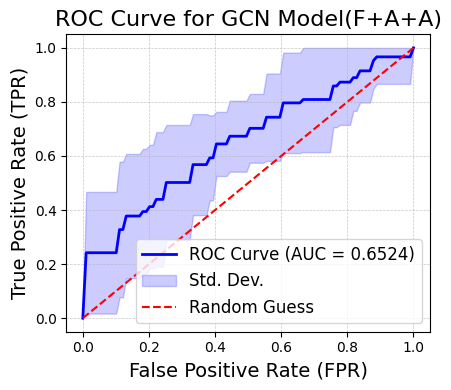

Epoch = 83
Best_mean_accuracy: 0.6478
Best mean_roc_auc: 0.6524
Best mean_precision: 0.6583
Best mean_recall: 0.4459


In [27]:
mean_train_accs = [acc / 10 for acc in train_accs]
mean_test_accs = [acc / 10 for acc in test_accs]
mean_precisions = [pre / 10 for pre in precisions]
mean_recalls = [recall / 10 for recall in recalls]

best_mean_accuracy = max(mean_test_accs)
best_epoch = mean_test_accs.index(best_mean_accuracy)
mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
mean_tpr[-1] = 1.0
mean_roc_auc = auc(mean_fpr, mean_tpr)

# Plot accuracy graphs over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per Epoch for F+A+A embedding')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC Curve for the best epoch
plt.figure(figsize=(4.5, 4))
plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'ROC Curve for GCN Model(F+A+A)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("./figures/Figure_gcn_FAA_ROC_AUC.pdf", format="pdf", dpi=300)

plt.show()
    
print(f"Epoch = {best_epoch}")
print(f"Best_mean_accuracy: {mean_test_accs[best_epoch]:.4f}")
print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")